In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import joblib
import keras_tuner as kt
import tensorflow.keras.utils as kutils

In [2]:
final_df = None

game_window = 4
data = pd.read_csv(f"sports-miner.fbref.2.csv")

data['date'] = pd.to_datetime(data['date'], dayfirst=True, unit="ms")

home_stats = data[["home_team","away_team","date","stats.possesion_home", "stats.passes_home", "stats.passes_completed_home", "stats.passes_away",
                   'stats.passes_completed_away','stats.fouls_home','stats.corners_home',"stats.score_home","stats.score_away",
                   "stats.cards_yellow_home","stats.cards_red_home","stats.shots_home", "stats.shots_away","stats.shots_on_target_home",
                   "stats.shots_on_target_away","season","league", "odds.B365H", "odds.B365D", "odds.B365A"]].copy()
home_stats.rename(columns={
        'home_team': 'team',
        'away_team': 'opponent',
        'stats.score_home': 'goals_for',
        'stats.score_away': 'goals_against',
        'stats.shots_home': 'shots',
        'stats.shots_away': 'shots_against',
        'stats.shots_on_target_home': 'shots_on_target',
        'stats.shots_on_target_away': 'shots_on_target_against',
        'stats.possesion_home': 'possesion',
        "stats.passes_home": "passes",
        "stats.passes_completed_home": "passes_completed",
        "stats.passes_away": "passes_against",
        "stats.passes_completed_away": "passes_completed_against",
        'stats.corners_home': 'corners',
        'stats.fouls_home': 'fouls',
        'stats.cards_yellow_home': 'yellow_cards',
        'stats.cards_red_home': 'red_cards'
    }, inplace=True)
home_stats['home_away'] = 1
home_stats['diff'] = home_stats['goals_for'] - home_stats['goals_against']
home_stats['result'] = home_stats['diff'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

away_stats = data[["home_team","away_team","date","stats.possesion_away", "stats.passes_home", "stats.passes_completed_home", "stats.passes_away",
                   'stats.passes_completed_away','stats.fouls_away','stats.corners_away',"stats.score_home","stats.score_away",
                   "stats.cards_yellow_away","stats.cards_red_away","stats.shots_home", "stats.shots_away","stats.shots_on_target_home",
                   "stats.shots_on_target_away","season","league", "odds.B365H", "odds.B365D", "odds.B365A"]].copy()
away_stats.rename(columns={
        'home_team': 'opponent',
        'away_team': 'team',
        'stats.score_home': 'goals_against',
        'stats.score_away': 'goals_for',
        'stats.shots_away': 'shots',
        'stats.shots_home': 'shots_against',
        'stats.shots_on_target_away': 'shots_on_target',
        'stats.shots_on_target_home': 'shots_on_target_against',
        'stats.possesion_away': 'possesion',
        "stats.passes_away": "passes",
        "stats.passes_completed_away": "passes_completed",
        "stats.passes_home": "passes_against",
        "stats.passes_completed_home": "passes_completed_against",
        'stats.corners_away': 'corners',
        'stats.fouls_away': 'fouls',
        'stats.cards_yellow_away': 'yellow_cards',
        'stats.cards_red_away': 'red_cards'
    }, inplace=True)
away_stats['home_away'] = 0
away_stats['diff'] = away_stats['goals_for'] - away_stats['goals_against']
away_stats['result'] = away_stats['diff'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)

team_stats.dropna() # check this
team_stats.sort_values(by='date', inplace=True)

aggregate_features = ['goals_for', 'goals_against', 'shots', 'shots_on_target', 'possesion', 'passes', 'passes_completed', 'corners', 'fouls', 'yellow_cards',
                      'red_cards', 'result', 'shots_on_target_against', "passes_against", "passes_completed_against" ]

processed_seasons = []

def compute_rolling_results(grp, window):
    grp = grp.sort_values(by='date')
    # Shift the values so that the current game is not included
    shifted_home = grp['home_away'].shift()
    shifted_diff = grp['diff'].shift()
    
    # Compute wins using the custom conditions:
    # For home games (home_away == 1): win if diff > 0
    # For away games (home_away == 0): win if diff > 0
    wins = (((shifted_home == 1) & (shifted_diff > 0)) |
            ((shifted_home == 0) & (shifted_diff > 0))).astype(int)
    
    # Draws: when diff == 0 (for both home and away)
    draws = (shifted_diff == 0).astype(int)
    
    # Losses:
    # For home games: loss if diff < 0
    # For away games: loss if diff < 0
    losses = (((shifted_home == 1) & (shifted_diff < 0)) |
              ((shifted_home == 0) & (shifted_diff < 0))).astype(int)
    
    grp['past_games_wins'] = wins.rolling(window=window, min_periods=1).sum()
    grp['past_games_draws'] = draws.rolling(window=window, min_periods=1).sum()
    grp['past_games_losses'] = losses.rolling(window=window, min_periods=1).sum()
    
    return grp

for season in team_stats['season'].unique():
    season_data = team_stats[team_stats['season'] == season].copy()
    
    # Apply rolling calculation for each feature
    for feature in aggregate_features:
        season_data[feature] = (
            season_data.groupby('team')[feature]
            .transform(lambda x: x.shift().rolling(window=game_window, min_periods=game_window).mean())
        )
    season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_results(grp, game_window))
    
    processed_seasons.append(season_data)

team_stats = pd.concat(processed_seasons, ignore_index=True)

team_stats = team_stats.dropna()
df = team_stats

home_df = df[df['home_away'] == 1].copy()
away_df = df[df['home_away'] == 0].copy()

home_df = home_df.rename(lambda x: x + '_home' if x not in ['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"] else x, axis=1)
away_df = away_df.rename(lambda x: x + '_away' if x not in ['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"] else x, axis=1)
final_df = pd.merge(
        home_df,
        away_df,
        left_on=['season', 'league', 'date', 'team', 'opponent', "odds.B365H", "odds.B365D", "odds.B365A"],
        right_on=['season', 'league', 'date', 'opponent', 'team', "odds.B365H", "odds.B365D", "odds.B365A"],
        suffixes=('_home', '_away')
)
final_df['target'] = final_df['diff_home'].map(lambda x: 0 if x < 0 else (1 if x == 0 else 2))
final_df.sort_values('date', inplace=True)

C:\Users\ghera\AppData\Local\Temp\ipykernel_40596\4149345474.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_results(grp, game_window))
C:\Users\ghera\AppData\Local\Temp\ipykernel_40596\4149345474.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_data = season_data.groupby('team').apply(lambda grp: compute_rolling_r

In [3]:
# Passes rates
final_df['passes_rate_home'] = np.where(
   final_df["passes_home"] == 0, 
   0, 
   final_df["passes_completed_home"] / final_df["passes_home"]
)
final_df['passes_rate_away'] = np.where(
   final_df["passes_away"] == 0, 
   0, 
   final_df["passes_completed_away"] / final_df["passes_away"]
)
final_df['passes_rate_against_home'] = np.where(
   final_df["passes_against_home"] == 0, 
   0, 
   final_df["passes_completed_against_home"] / final_df["passes_against_home"]
)
final_df['passes_rate_against_away'] = np.where(
   final_df["passes_against_away"] == 0, 
   0, 
   final_df["passes_completed_against_away"] / final_df["passes_against_away"]
)

# Shots rates
final_df['shots_rate_home'] = np.where(
   final_df["shots_home"] == 0, 
   0, 
   final_df["shots_on_target_home"] / final_df["shots_home"]
)
final_df['shots_rate_away'] = np.where(
   final_df["shots_away"] == 0, 
   0, 
   final_df["shots_on_target_away"] / final_df["shots_away"]
)
final_df['shots_rate_against_home'] = np.where(
   final_df["shots_against_home"] == 0, 
   0, 
   final_df["shots_on_target_against_home"] / final_df["shots_against_home"]
)
final_df['shots_rate_against_away'] = np.where(
   final_df["shots_against_away"] == 0, 
   0, 
   final_df["shots_on_target_against_away"] / final_df["shots_against_away"]
)

final_df['cards_home'] = final_df['yellow_cards_home'] + 3 * final_df["red_cards_home"]
final_df['cards_away'] = final_df['yellow_cards_away'] + 3 * final_df["red_cards_away"]

In [13]:
feature_columns = ['goals_for_home', 'goals_against_home',
                           'shots_home', 'shots_on_target_home',
                           'shots_against_home' ,'shots_on_target_against_home',
                           # "shots_rate_home", "shots_rate_against_home",
                           # 'passes_home', 
                           # "passes_against_home",
                           'passes_completed_home',
                           "passes_completed_against_home",
                           # "passes_rate_home", "passes_rate_against_home",
                           'possesion_home',
                           # 'corners_home', 'fouls_home',
                           # "cards_home",
                           "past_games_losses_home", "past_games_draws_home", "past_games_wins_home",
                           # 'result_home',
                           'goals_for_away', 'goals_against_away',
                           'shots_away', 'shots_on_target_away',
                           'shots_against_away', 'shots_on_target_against_away', 
                           # "shots_rate_away", "shots_rate_against_away",
                           # 'passes_away',
                           # "passes_against_away",
                           'passes_completed_away',
                           "passes_completed_against_away", 
                           # "passes_rate_away", "passes_rate_against_away",
                           'possesion_away',
                           # 'corners_away', 'fouls_away',
                           # "cards_away",
                           "past_games_losses_away", "past_games_draws_away", "past_games_wins_away"
                           # 'result_away'
                  ]
# feature_columns.extend(['yellow_cards_home', 'red_cards_home', 'yellow_cards_away', 'red_cards_away'])

scaler = MinMaxScaler()
scaler.fit(final_df[feature_columns])
to_split = final_df[feature_columns]
to_split = scaler.transform(final_df[feature_columns])

X_train, X_test, y_train, y_test = train_test_split(to_split, final_df[[ "odds.B365H", "odds.B365D", "odds.B365A", 'target']], test_size=0.10, random_state=42)

print(X_train.shape)
print(X_test.shape)
print("A: " + str(len(final_df.loc[final_df['target'] == 0])))
print("D: " + str(len(final_df.loc[final_df['target'] == 1])))
print("H: " + str(len(final_df.loc[final_df['target'] == 2])))

(16870, 24)
(1875, 24)
A: 5759
D: 4622
H: 8364


In [5]:
final_df[["team_home", "opponent_home", "date", "possesion_home", "possesion_away",
          "past_games_wins_home", "past_games_draws_home", "past_games_losses_home",
         "past_games_wins_away", "past_games_draws_away", "past_games_losses_away",
         "target"]].head()

,team_home,opponent_home,date,possesion_home,possesion_away,past_games_wins_home,past_games_draws_home,past_games_losses_home,past_games_wins_away,past_games_draws_away,past_games_losses_away,target
272,Swansea City,Southampton,2014-09-19 21:00:00,49.00,54.00,3.0,0.0,1.0,2.0,1.0,1.0,0
323,West Ham United,Liverpool,2014-09-19 21:00:00,49.00,54.50,1.0,1.0,2.0,2.0,0.0,2.0,2
204,Queens Park Rangers,Stoke City,2014-09-19 21:00:00,39.50,51.75,1.0,0.0,3.0,1.0,1.0,2.0,1
34,Burnley,Sunderland,2014-09-19 21:00:00,43.75,46.25,0.0,2.0,2.0,0.0,3.0,1.0,1
187,Newcastle United,Hull City,2014-09-19 21:00:00,54.50,47.00,0.0,2.0,2.0,1.0,2.0,1.0,1


# Validation dataset

## Constants

In [ ]:
from pymongo import MongoClient
import time
import datetime
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
import numpy as np

mongoClient = MongoClient("mongodb+srv://u:p@cluster.ywrlr.mongodb.net/score-lab?retryWrites=true&w=majority&appName=Cluster", connectTimeoutMS=300000)
collectionPredictions = mongoClient["score-lab"]["predictions"]
mongoClientLocal = MongoClient("mongodb://localhost:27017/")
collectionData = mongoClientLocal["sports-miner"]["fbref"]

TEAM_MAPPINGS = {
    "Borussia Dortmund": "Dortmund",
    "SC Freiburg": "Freiburg",
    "VfL Wolfsburg": "Wolfsburg",
    "VfL Bochum": "Bochum",
    "FSV Mainz 05": "Mainz 05",
    "FC St. Pauli": "St. Pauli",
    "Borussia Mönchengladbach": "Mönchengladbach",
    "FC Koln": "Köln",
    "FC Augsburg": "Augsburg",
    "1. FC Heidenheim": "Heidenheim",
    "Bayern München": "Bayern Munich",
    "1899 Hoffenheim": "Hoffenheim",
    "VfB Stuttgart": "Stuttgart",
    "VfL Wolfsburg": "Wolfsburg",
    "Alaves": "Alavés",
    "Atletico Madrid": "Atlético Madrid",
    "Leganes": "Leganés",
    "AC Milan": "Milan",
    "Inter": "Internazionale",
    "Verona": "Hellas Verona",
    "AS Roma": "Roma",
    "Saint Etienne": "Saint-Étienne",
    "LE Havre": "Le Havre",
    "Stade Brestois 29": "Brest",
    "Paris Saint Germain": "Paris Saint-Germain",
    "Leicester": "Leicester City",
    "Newcastle": "Newcastle United",
    "Brighton": "Brighton & Hove Albion",
    "Wolves": "Wolverhampton Wanderers",
    "West Ham": "West Ham United",
    "Ipswich": "Ipswich Town",
    "Tottenham": "Tottenham Hotspur",
    "Almere City FC": "Almere City",
    "Waalwijk": "RKC Waalwijk",
    "Heracles": "Heracles Almelo",
    "GO Ahead Eagles": "Go Ahead Eagles",
    "PEC Zwolle": "Zwolle",
    "SC Braga": "Braga",
    "GIL Vicente": "Gil Vicente FC",
    "AVS": "AVS Futebol",
    "Famalicao": "Famalicão",
    "FC Porto": "Porto",
    "Guimaraes": "Vitória Guimarães"
};

# feature_columns = ['goals_for_home', 'goals_against_home',
#                            'shots_home', 'shots_on_target_home',
#                            'shots_against_home' ,'shots_on_target_against_home',
#                            # "shots_rate_home", "shots_rate_against_home",
#                            # 'passes_home', 
#                            # "passes_against_home",
#                            'passes_completed_home',
#                            "passes_completed_against_home",
#                            # "passes_rate_home", "passes_rate_against_home",
#                            'possesion_home',
#                            # 'corners_home', 'fouls_home',
#                            # "cards_home",
#                            "past_games_losses_home", "past_games_draws_home", "past_games_wins_home",
#                            # 'result_home',
#                            'goals_for_away', 'goals_against_away',
#                            'shots_away', 'shots_on_target_away',
#                            'shots_against_away', 'shots_on_target_against_away', 
#                            # "shots_rate_away", "shots_rate_against_away",
#                            # 'passes_away',
#                            # "passes_against_away",
#                            'passes_completed_away',
#                            "passes_completed_against_away", 
#                            # "passes_rate_away", "passes_rate_against_away",
#                            'possesion_away',
#                            # 'corners_away', 'fouls_away',
#                            # "cards_away",
#                            "past_games_losses_away", "past_games_draws_away", "past_games_wins_away"
#                            # 'result_away'
#                   ]

def notGameType(gameType):
    if gameType == "_home":
        return "_away"
    return "_home"

TIMESTAMP_LIMIT = 40 * 24 * 60 * 60 * 1000 # 45 days
step = 0
final_df_validation = pd.DataFrame()
loggging = False

## Create dataset

In [64]:
predictions = collectionPredictions.find({"league.id": {"$nin": [2,3]} }).sort({"date": -1}).to_list() # The query should be something related to current date/ season etc. This is a first itteration for now every time
for prediction in predictions:
    fixture = prediction["fixture"]
    timestamp = int(time.mktime(datetime.datetime.strptime(prediction["date"],
                                            "%Y-%m-%d").timetuple())) * 1000
    home_team_query = prediction['teams']['home']['name']
    away_team_query = prediction['teams']['away']['name']

    if (TEAM_MAPPINGS.get(prediction['teams']['home']['name'])):
        home_team_query = TEAM_MAPPINGS[prediction['teams']['home']['name']]
    if (TEAM_MAPPINGS.get(prediction['teams']['away']['name'])):
        away_team_query = TEAM_MAPPINGS[prediction['teams']['away']['name']]

    home_team = collectionData.find({"$or": [{"home_team": home_team_query}, {"away_team": home_team_query}], "date": { "$lt": timestamp, "$gt": timestamp - TIMESTAMP_LIMIT}}).sort("date", -1).limit(4).to_list()
    away_team = collectionData.find({"$or": [{"home_team": away_team_query}, {"away_team": away_team_query}], "date": { "$lt": timestamp, "$gt": timestamp - TIMESTAMP_LIMIT}}).sort("date", -1).limit(4).to_list()

    if len(home_team) < 4 or len(away_team) < 4:
        # print("Not enough data for ", home_team_query, away_team_query)
        if (len(home_team) == 0 or len(away_team) == 0):
            print("Not enough data for ", home_team_query, away_team_query)
            print("CAUTION!!! Home team: ", len(home_team), " Away team: ", len(away_team))
        continue

    stats_to_consider = [
        "shots",
        "shots_on_target",
        "passes_completed",
        "possesion",
    ]

    stats_to_consider_against = [
        "shots_on_target",
        "shots",
        "passes_completed",
    ]

    home_team_stats = {}
    wins = 0
    draws = 0
    losses = 0
    for game in home_team:
        try:
            game_type = "_home"
            if game["home_team"] != home_team_query:
                game_type = "_away"

            if game["stats"]["score" + game_type] > game["stats"]["score" + notGameType(game_type)]:
                wins += 1
            elif game["stats"]["score" + game_type] == game["stats"]["score" + notGameType(game_type)]:
                draws += 1
            else:
                losses += 1
            
            if home_team_stats.get("goals_for" + "_home", None) == None:
                home_team_stats["goals_for" + "_home"] = 0
            if home_team_stats.get("goals_against" + "_home", None) == None:
                home_team_stats["goals_against" + "_home"] = 0

            home_team_stats["goals_for" + "_home"] += game["stats"]["score" + game_type]
            home_team_stats["goals_against" + "_home"] += game["stats"]["score" + notGameType(game_type)]

            for feature in stats_to_consider:
                currentFeature = feature + game_type
                if home_team_stats.get(feature + "_home", None) != None:
                    home_team_stats[feature + "_home"] += game["stats"].get(currentFeature)
                else:
                    home_team_stats[feature + "_home"] = game["stats"].get(currentFeature)
                
            for feature in stats_to_consider_against:
                currentFeature = feature + notGameType(game_type)
                if home_team_stats.get(feature + "_against_home", None) != None:
                    home_team_stats[feature + "_against_home"] += game["stats"].get(currentFeature)
                else:
                    home_team_stats[feature + "_against_home"] = game["stats"].get(currentFeature)
        except Exception as e:
            if logging:
                print(game)

    home_team_stats["past_games_wins_home"] = wins
    home_team_stats["past_games_draws_home"] = draws
    home_team_stats["past_games_losses_home"] = losses

    away_team_stats = {}
    wins = 0
    draws = 0
    losses = 0
    for game in away_team:
        try:
            game_type = "_home"
            if game["home_team"] != away_team_query:
                game_type = "_away"

            if game["stats"]["score" + game_type] > game["stats"]["score" + notGameType(game_type)]:
                wins += 1
            elif game["stats"]["score" + game_type] == game["stats"]["score" + notGameType(game_type)]:
                draws += 1
            else:
                losses += 1
            
            if away_team_stats.get("goals_for" + "_away", None) == None:
                away_team_stats["goals_for" + "_away"] = 0
            if away_team_stats.get("goals_against" + "_away", None) == None:
                away_team_stats["goals_against" + "_away"] = 0

            away_team_stats["goals_for" + "_away"] += game["stats"]["score" + game_type]
            away_team_stats["goals_against" + "_away"] += game["stats"]["score" + notGameType(game_type)]

            for feature in stats_to_consider:
                currentFeature = feature + game_type
                if away_team_stats.get(feature + "_away", None) != None:
                    away_team_stats[feature + "_away"] += game["stats"].get(currentFeature)
                else:
                    away_team_stats[feature + "_away"] = game["stats"].get(currentFeature)
                
            for feature in stats_to_consider_against:
                currentFeature = feature + notGameType(game_type)
                if away_team_stats.get(feature + "_against_away", None) != None:
                    away_team_stats[feature + "_against_away"] += game["stats"].get(currentFeature)
                else:
                    away_team_stats[feature + "_against_away"] = game["stats"].get(currentFeature)
        except Exception as e:
            if logging:
                print(game)
    
    away_team_stats["past_games_wins_away"] = wins
    away_team_stats["past_games_draws_away"] = draws
    away_team_stats["past_games_losses_away"] = losses

    for key, value in home_team_stats.items():
        if not key.startswith("past_games"):
            home_team_stats[key] = value / 4
    for key, value in away_team_stats.items():
        if not key.startswith("past_games"):
            away_team_stats[key] = value / 4

    df1 = pd.DataFrame([home_team_stats])
    df2 = pd.DataFrame([away_team_stats])
    df = pd.concat([df1, df2], axis=1)
    current_game = collectionData.find_one({"home_team": home_team_query, "away_team": away_team_query, "season": "2024-2025"})

    if current_game == None: # TODO: This is big problem
        if logging:
            print(home_team_query, away_team_query)
            print(prediction.get("fixture").get("id"))
        continue

    result = None
    if current_game.get("odds", None) == None:
        if logging:
            print(home_team_query, away_team_query)
            print(prediction.get("fixture").get("id"))
        continue

    result = current_game["stats"]["score_home"] - current_game["stats"]["score_away"]
    if result > 0:
        result = 2
    elif result < 0:
        result = 0
    else:
        result = 1

    df3 = pd.DataFrame([result, current_game['odds']['B365A'], current_game['odds']['B365D'], current_game['odds']['B365H']])
    
    extraInfo = pd.DataFrame([{
        "target": result,
        "odds.B365A": current_game['odds']['B365A'],
        "odds.B365D": current_game['odds']['B365D'],
        "odds.B365H": current_game['odds']['B365H']
    }])
    df = pd.concat([df, extraInfo], axis=1)
    final_df_validation = pd.concat([final_df_validation, df], axis=0)

Not enough data for  Heidenheim SV Elversberg
CAUTION!!! Home team:  4  Away team:  0
Not enough data for  Metz Reims
CAUTION!!! Home team:  0  Away team:  4
Not enough data for  Dordrecht Willem II
CAUTION!!! Home team:  0  Away team:  4
Not enough data for  Den Bosch Telstar
CAUTION!!! Home team:  0  Away team:  0
Roma Milan
1223964
Parma Napoli
1223963
Monza Empoli
1223962
Juventus Udinese
1223960
Hellas Verona Como
1223958
Fiorentina Bologna
1223956
Cagliari Venezia
1223955
Sparta Rotterdam PSV Eindhoven
1213746
Heerenveen Feyenoord
1213745
RKC Waalwijk Go Ahead Eagles
1213744
Zwolle Groningen
1213743
NAC Breda Willem II
1213742
Heracles Almelo NEC Nijmegen
1213741
Fortuna Sittard Utrecht
1213740
AZ Alkmaar Almere City
1213739
Not enough data for  Dordrecht De Graafschap
CAUTION!!! Home team:  0  Away team:  0
Not enough data for  ADO Den Haag Telstar
CAUTION!!! Home team:  0  Away team:  0
Not enough data for  Cambuur Den Bosch
CAUTION!!! Home team:  0  Away team:  0
Not enough da

## Format

In [65]:
X_test_validation = scaler.transform(final_df_validation[feature_columns])
y_test_validation = final_df_validation[[ "odds.B365H", "odds.B365D", "odds.B365A", 'target']]

# REST

## Basic model

In [6]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(final_df['target']),
                                     y=final_df['target'])

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Computed class_weight_dict:", class_weight_dict)

rf_model = RandomForestClassifier(
    n_estimators=250,          # Increase number of trees
    max_depth=20,              # Slightly deeper trees
    min_samples_split=10,       # More flexible splitting
    min_samples_leaf=10,        # More flexible leaves
    max_features='sqrt',       # Common choice to reduce correlation
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=10
)

hgb_model = HistGradientBoostingClassifier(
    max_iter=400,               # More boosting iterations
    max_depth=15,               # Reasonably deep
    learning_rate=0.03,         # Slightly smaller LR
    # min_samples_leaf=5,         # Controls overfitting
    # l2_regularization=1.0,      # Regularization to reduce overfit
    early_stopping=True,
    scoring='balanced_accuracy',# Makes sense in imbalanced data
    random_state=10
)

cat_model = CatBoostClassifier(
    iterations=500,            # More iterations
    # depth=8,                   # Controls model complexity
    learning_rate=0.03,        # Slightly smaller LR
    # l2_leaf_reg=3,             # L2 regularization
    # border_count=128,          # Number of splits for numerical features
    loss_function='MultiClass',
    eval_metric='MultiClass',
    auto_class_weights='Balanced',  # Let CatBoost internally handle imbalance
    early_stopping_rounds=50,
    random_state=10,
    verbose=0
)

xgb_model = XGBClassifier(
    n_estimators=350,          # More boosting rounds
    max_depth=15,               # Deeper trees
    min_child_weight=3,        # Further control overfitting
    learning_rate=0.03,        # Smaller learning rate
    # colsample_bytree=0.9,      # Subsample features
    # subsample=0.8,             # Subsample rows
    objective='multi:softprob',# Probability outputs
    num_class=len(np.unique(y_train['target'])),
    eval_metric='mlogloss',
    use_label_encoder=False,   # Avoid label encoder warnings
    n_jobs=-1,
    random_state=10
)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 256, 64),   # A common multi-layer architecture
    activation='relu',
    solver='adam',
    alpha=1e-4,                          # L2 regularization
    # learning_rate='adaptive',            # Adjust LR if not improving, only for solver='sgd'
    learning_rate_init=1e-3,
    max_iter=500,                        # More epochs
    batch_size=64,                       # Smaller batch size can help generalization
    early_stopping=True,                 # Stops when validation score isn't improving
    warm_start=True,
    # class_weight='balanced',             # Handle imbalance in MLP
    random_state=10,
    verbose=False
)

rf_model.fit(X_train, y_train['target'])
# hgb_model.fit(X_train, y_train['target'])
cat_model.fit(X_train, y_train['target'])
xgb_model.fit(X_train, y_train['target'])
# mlp_model.fit(X_train, y_train['target'])

y_pred_rf  = rf_model.predict(X_test)
# y_pred_hgb = hgb_model.predict(X_test)
y_pred_cat = cat_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
# y_pred_mlp = mlp_model.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

evaluate_model('Random Forest', y_test['target'], y_pred_rf)
# evaluate_model('HistGradientBoosting', y_test['target'], y_pred_hgb)
evaluate_model('CatBoost', y_test['target'], y_pred_cat)
evaluate_model('XGBoost', y_test['target'], y_pred_xgb)
# evaluate_model('MLP Classifier', y_test['target'], y_pred_mlp)

# Classification Report
# print('Classification Report:')
# print(classification_report(y_test, y_pred, target_names=['Loss', 'Draw', 'Win']))

Computed class_weight_dict: {0: 1.0849684551716154, 1: 1.351867878263378, 2: 0.7470508528614698}


C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Random Forest Performance:
Accuracy: 0.4992
Balanced Accuracy: 0.4664
              precision    recall  f1-score   support

    Away Win       0.48      0.54      0.51       580
        Draw       0.33      0.24      0.28       472
    Home Win       0.58      0.62      0.60       823

    accuracy                           0.50      1875
   macro avg       0.46      0.47      0.46      1875
weighted avg       0.49      0.50      0.49      1875


CatBoost Performance:
Accuracy: 0.4805
Balanced Accuracy: 0.4630
              precision    recall  f1-score   support

    Away Win       0.48      0.51      0.50       580
        Draw       0.30      0.34      0.32       472
    Home Win       0.61      0.54      0.57       823

    accuracy                           0.48      1875
   macro avg       0.46      0.46      0.46      1875
weighted avg       0.49      0.48      0.49      1875


XGBoost Performance:
Accuracy: 0.5029
Balanced Accuracy: 0.4459
              precision    recall  f

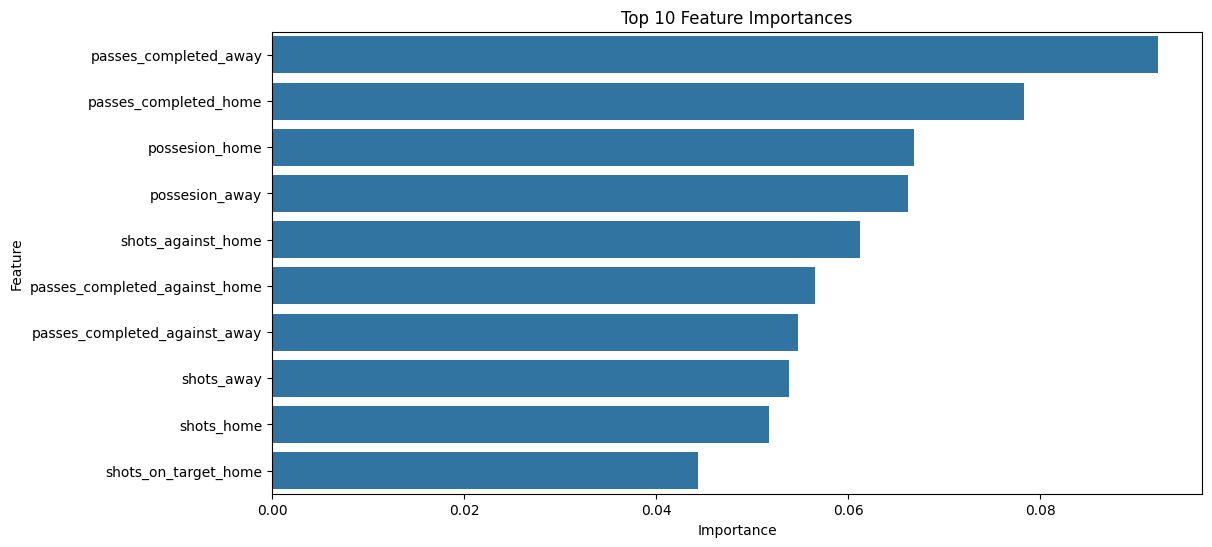

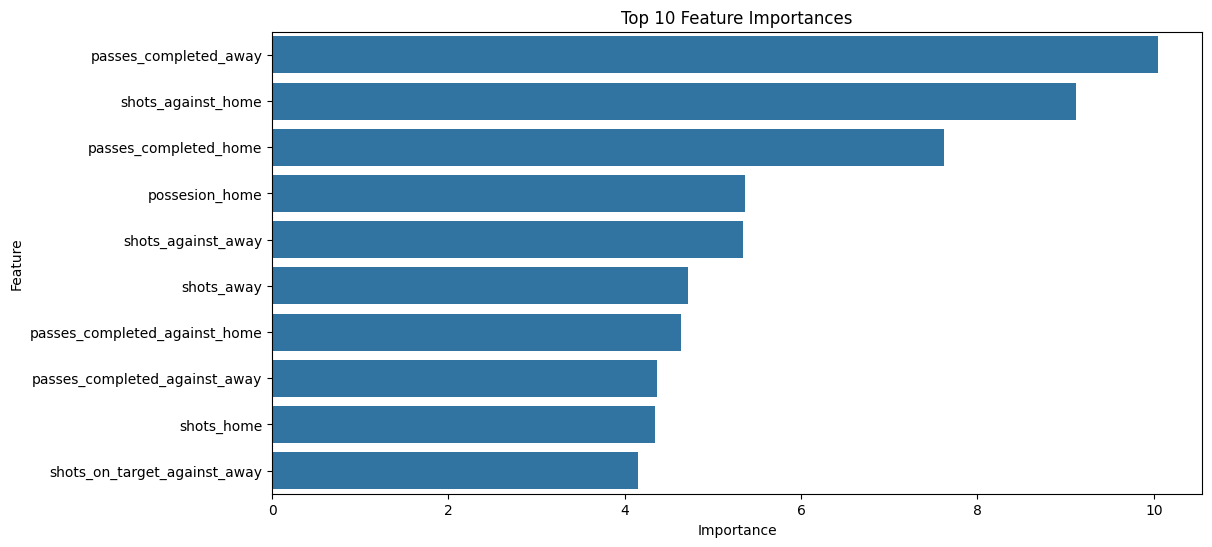

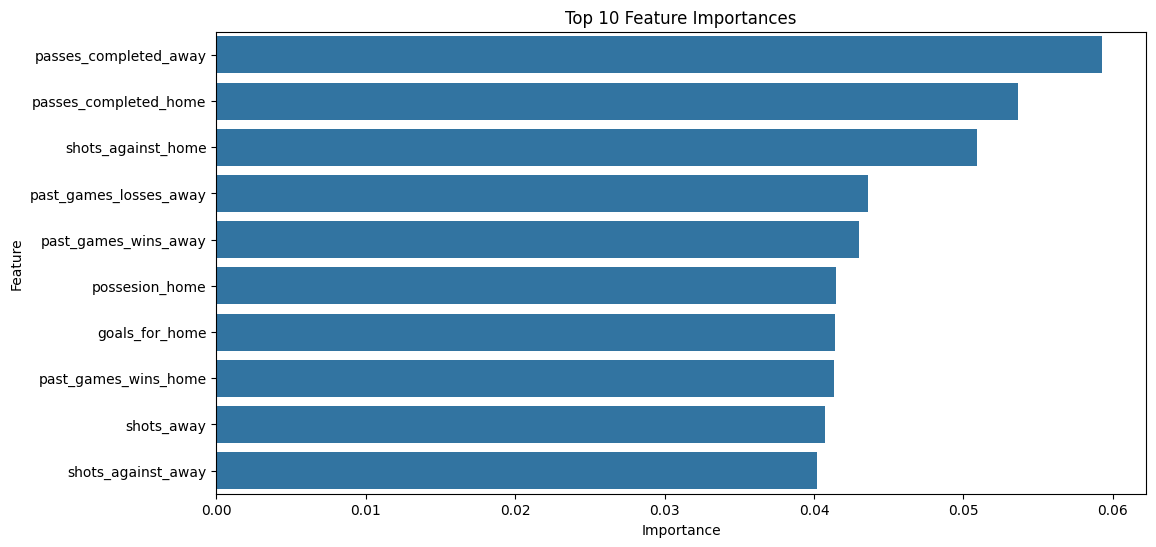

In [7]:
# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

importances = [rf_model.feature_importances_, cat_model.feature_importances_, xgb_model.feature_importances_]
feature_names = feature_columns

for elem in importances:
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': elem
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12,6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.show()

## NN

In [57]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(final_df['target']),
                                     y=final_df['target'])

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

def build_model(hp):
    model = Sequential()

    # Define the input shape explicitly using the Input layer
    model.add(Input(shape=(X_train.shape[1],)))
    
    # First hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=512, step=32),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=384, step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Second hidden layer: tune number of units and dropout rate
    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=256, step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer for 3-class classification
    model.add(Dense(3, activation='softmax'))
    
    # Tune learning rate for the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create a Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=40,
    factor=3,
    directory='my_dir',  # Directory to store tuning results
    project_name='new_db_classic'
)

# Early stopping callback to avoid overtraining
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run the hyperparameter search
tuner.search(X_train, kutils.to_categorical(y_train['target']), epochs=50, validation_split=0.15, callbacks=[stop_early], class_weight = class_weight_dict)

# Retrieve the best model found during the search
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Reloading Tuner from my_dir\new_db_classic\tuner0.json

Best Hyperparameters:
{'units_1': 256, 'dropout_1': 0.1, 'units_2': 256, 'dropout_2': 0.4, 'units_3': 176, 'dropout_3': 0.4, 'lr': 0.005459594548060569, 'tuner/epochs': 40, 'tuner/initial_epoch': 14, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0069'}


C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [55]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train['target']), y=y_train['target'])
# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(final_df['target']),
#                                      y=final_df['target'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

num_classes = len(np.unique(y_train['target']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], num_classes)
y_test_encoded = keras.utils.to_categorical(y_test['target'], num_classes)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    BatchNormalization(),
    Dropout(0.3),  # Regularization

    Dense(128, activation='relu'),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),  # Hidden layer 2
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

model.compile(
    optimizer=Adam(learning_rate=0.005),  # Adam optimizer with learning rate
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_encoded,
    validation_split=0.1,
    epochs=50,  # Start with 50 epochs, can tune later
    batch_size=64,  # Can be adjusted based on performance
    class_weight=class_weight_dict,  # Handling class imbalance
    verbose=0
)

test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
# validate_with_odds(X_test, y_test)

C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4850 - loss: 1.0038

Test Accuracy: 0.4843
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

        Loss       0.49      0.46      0.47       580
        Draw       0.28      0.25      0.26       472
         Win       0.57      0.64      0.61       823

    accuracy                           0.48      1875
   macro avg       0.45      0.45      0.45      1875
weighted avg       0.47      0.48      0.48      1875



## Helper functions

In [96]:
def validate_with_odds(model, X_test, y_test, min_score = [0.5, 0.4, 0.5], min_odd = [0, 0, 0], logging=True):
    total = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    correct = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    p1_count = 0
    p2_count = 0
    
    selected_info = {
        "A": [],
        "D": [],
        "H": []
    }
    odds = {
        "A": 0,
        "D": 0,
        "H": 0
    }

    probabilities = model.predict(X_test, verbose=0)
    prediction = np.argmax(probabilities, axis=1)
    target = np.array(y_test['target'])
    odd_away = np.array(y_test['odds.B365A'])
    odd_draw = np.array(y_test['odds.B365D'])
    odd_home = np.array(y_test['odds.B365H'])

    mask_away_total = (prediction[:] == 0) & (probabilities[:, 0] >= min_score[0])
    mask_away_corect = (prediction[:] == 0) & (target == 0) & (probabilities[:, 0] >= min_score[0])
    if min_odd[0] != 0:
        mask_away_total = mask_away_total & (odd_away[:] >= min_odd[0])
        mask_away_corect = mask_away_corect & (probabilities[:, 0] >= min_score[0])
    correct['A'] = np.sum(mask_away_corect)
    total['A'] = np.sum(mask_away_total)
    odds['A'] = np.sum(odd_away[mask_away_corect])

    mask_draw_total = (prediction[:] == 1) & (probabilities[:, 1] >= min_score[1])
    mask_draw_corect = (prediction[:] == 1) & (target == 1) & (probabilities[:, 1] >= min_score[1])
    if min_odd[1] != 0:
        mask_draw_total = mask_draw_total & (odd_draw[:] >= min_odd[1])
        mask_draw_corect = mask_draw_corect & (odd_draw[:] >= min_odd[1])
    correct['D'] = np.sum(mask_draw_corect)
    total['D'] = np.sum(mask_draw_total)
    odds['D'] = np.sum(odd_draw[mask_draw_corect])

    mask_home_total = (prediction[:] == 2) & (probabilities[:, 2] >= min_score[2])
    mask_home_corect = (prediction[:] == 2) & (target == 2) & (probabilities[:, 2] >= min_score[2])
    if min_odd[2] != 0:
        mask_home_total = mask_home_total & (odd_home[:] >= min_odd[2])
        mask_home_corect = mask_home_corect & (odd_home[:] >= min_odd[2])
    correct['H'] = np.sum(mask_home_corect)
    total['H'] = np.sum(mask_home_total)
    odds['H'] = np.sum(odd_home[mask_home_corect])
    
    final_win = 0
    final_total = 0
    if logging:
        for key in odds.keys():
            print("-------------------")
            print("Total count:", total[key])
            print("Correct count:", correct[key])
            if (total[key] == 0):
                continue
            print("Prediction %:", correct[key] / total[key])
            print("Total odd won: ", odds[key] - total[key])
            print("Expected win per game: ", (odds[key] - total[key]) / total[key])
            final_win += odds[key] - total[key]
            final_total += total[key]
        print("----------FINAL---------")
        print("Total odd won: ", final_win)
        print("Expected win per game: ", final_win / final_total )
        print("Percentage of games: ", final_total / len(y_test))

    return {
        "total": total,
        "correct": correct,
        "odds": odds,
        "final_win": final_win,
        "final_total": final_total
    }

In [97]:
def create_charts_by_type(probabilities, predictions, target, odds, game_type, min_prob=0.35, max_prob=0.8, step=0.01):
    prob_ranges = np.arange(min_prob, max_prob + step, step)

    graph_name = ""
    if game_type == 0:
        graph_name = "Away"
    elif game_type == 1:
        graph_name = "Draw"
    else:
        graph_name = "Home"
        
    # Initialize containers for statistics
    total_odds = []
    mean_odds = []
    win_probs = []
    games_count = []
    probability = []
    
    # Calculate statistics for each probability range
    for prob in prob_ranges[:-1]:
        mask = (probabilities[:, game_type] >= prob) & (y_pred[:] == game_type)
        games_in_range = np.sum(mask)
    
        if games_in_range > 10:
            wins_in_range = np.sum((predictions[mask] == game_type) & (predictions[mask] == target[mask]))
            odd_mask = (predictions[:] == game_type) & (target[:] == game_type) & mask
            total_odd_win = np.sum(odds[odd_mask]) - games_in_range
            mean_odd = np.mean(odds[odd_mask])
            win_prob = wins_in_range / games_in_range
    
            total_odds.append(total_odd_win)
            mean_odds.append(mean_odd)
            win_probs.append(win_prob)
            probability.append(prob)
            games_count.append(games_in_range)
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 9))
    ax1 = axs[0,0]
    ax2 = axs[0,1]
    ax3 = axs[1,0]
    ax4 = axs[1,1]
    
    scatter1 = ax1.scatter(probability, total_odds, c=games_count, cmap='viridis', s=100)
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Total Odd Win')
    ax1.set_title(f'{graph_name}: Win Probability vs Total Odd Win')
    ax1.grid(True, alpha=0.3)
    fig.colorbar(scatter1, ax=ax1, label='Number of Games')
    
    # Add annotations for number of games
    for i, (x, y, count) in enumerate(zip(probability, total_odds, games_count)):
        ax1.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot 2: Win Probability vs Mean Odd
    scatter2 = ax2.scatter(probability, mean_odds, c=games_count, cmap='viridis', s=100)
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Mean Odd')
    ax2.set_title(f'{graph_name}: Win Probability vs Mean Odd')
    ax2.grid(True, alpha=0.3)
    fig.colorbar(scatter2, ax=ax2, label='Number of Games')
    
    # Add annotations for number of games
    for i, (x, y, count) in enumerate(zip(probability, mean_odds, games_count)):
        ax2.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

    scatter3 = ax3.scatter(win_probs, total_odds, c=games_count, cmap='viridis', s=100)
    ax3.set_xlabel('Win Probability')
    ax3.set_ylabel('Total Odd Win')
    ax3.set_title(f'{graph_name}: Win Probability vs Total Odd Win')
    ax3.grid(True, alpha=0.3)
    fig.colorbar(scatter3, ax=ax3, label='Number of Games')
    
    # Add annotations for number of games
    for i, (x, y, count) in enumerate(zip(win_probs, total_odds, games_count)):
        ax3.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Plot 2: Win Probability vs Mean Odd
    scatter4 = ax4.scatter(probability, win_probs, c=games_count, cmap='viridis', s=100)
    ax4.set_xlabel('Probability')
    ax4.set_ylabel('Win Probability')
    ax4.set_title(f'{graph_name}: Win Probability vs Mean Odd')
    ax4.grid(True, alpha=0.3)
    fig.colorbar(scatter4, ax=ax4, label='Number of Games')
    
    # Add annotations for number of games
    for i, (x, y, count) in enumerate(zip(probability, win_probs, games_count)):
        ax4.annotate(f'{count}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## TESTING

In [77]:
print("Loss: " + str(len(y_test.loc[y_test['target'] == 0])))
print("Draw: " + str(len(y_test.loc[y_test['target'] == 1])))
print("Win: " + str(len(y_test.loc[y_test['target'] == 2])))

print("Loss: " + str(len(y_test_validation.loc[y_test_validation['target'] == 0])))
print("Draw: " + str(len(y_test_validation.loc[y_test_validation['target'] == 1])))
print("Win: " + str(len(y_test_validation.loc[y_test_validation['target'] == 2])))

Loss: 580
Draw: 472
Win: 823
Loss: 584
Draw: 442
Win: 754


In [103]:
values = np.arange(0.35, 0.63 + 0.05, 0.02)
intervals = np.array([[x, x, x] for x in values])

models = tuner.get_best_models(num_models=50)
step = 0 
final_version = {}
for model in models:
    maxim_testing = {
        "A": 0,
        "D": 0,
        "H": 0,
    }
    maxim_validation = {
        "A": 0,
        "D": 0,
        "H": 0,
    }
    best_version = {
        "A": 0,
        "D": 0,
        "H": 0,
    }
    for interval in intervals:
        testing = validate_with_odds(model, X_test, y_test, interval, logging=False)
        validation = validate_with_odds(model, X_test_validation, y_test_validation, interval, logging=False)

        if maxim_testing['A'] == 0: 
            maxim_testing['A'] = {
                "step": 0.35,
                "value": testing['odds']['A'] - testing['total']['A'] - 100
            }
            maxim_testing['D'] = {
                "step": 0.35,
                "value": testing['odds']['D'] - testing['total']['D'] - 100
            }
            maxim_testing['H'] = {
                "step": 0.35,
                "value": testing['odds']['H'] - testing['total']['H'] - 100
            }
            maxim_validation['A'] = {
                "step": 0.35,
                "value": validation['odds']['A'] - validation['total']['A'] - 100
            }
            maxim_validation['D'] = {
                "step": 0.35,
                "value": validation['odds']['D'] - validation['total']['D'] - 100
            }
            maxim_validation['H'] = {
                "step": 0.35,
                "value": validation['odds']['H'] - validation['total']['H'] - 100
            }
            best_version['A'] = {
                "step": 0.35,
                "value": validation['odds']['A'] - validation['total']['A'] + testing['odds']['A'] - testing['total']['A'] - 100
            }
            best_version['D'] = {
                "step": 0.35,
                "value": validation['odds']['D'] - validation['total']['D'] + testing['odds']['D'] - testing['total']['D'] - 100
            }
            best_version['H'] = {
                "step": 0.35,
                "value": validation['odds']['H'] - validation['total']['H'] + testing['odds']['H'] - testing['total']['H'] - 100
            }
            continue

        for type_of_game, limit, index in [['A', 100, 0], ['D', 25, 1], ['H', 125, 2]]:
            if (maxim_validation[type_of_game]['value'] < testing['odds'][type_of_game] - testing['total'][type_of_game]) and testing['total'][type_of_game] > limit:
                 maxim_validation[type_of_game] = {
                    "step": interval[index],
                    "value": testing['odds'][type_of_game] - testing['total'][type_of_game]
                }
            if (maxim_validation[type_of_game]['value'] < validation['odds'][type_of_game] - validation['total'][type_of_game]) and validation['total'][type_of_game] > limit:
                 maxim_validation[type_of_game] = {
                    "step": interval[index],
                    "value": validation['odds'][type_of_game] - validation['total'][type_of_game]
                }

            if ((best_version[type_of_game]['value'] < validation['odds'][type_of_game] - validation['total'][type_of_game] + testing['odds'][type_of_game] - testing['total'][type_of_game])
            and validation['total'][type_of_game] > limit and testing['total'][type_of_game] > limit 
            and validation['odds'][type_of_game] - validation['total'][type_of_game] > 0 and testing['odds'][type_of_game] - testing['total'][type_of_game] > 0):
                 best_version[type_of_game] = {
                    "step": interval[index],
                    "value": validation['odds'][type_of_game] - validation['total'][type_of_game] + testing['odds'][type_of_game] - testing['total'][type_of_game],
                    "testing": testing['odds'][type_of_game] - testing['total'][type_of_game],
                    "testing_total": testing['total'][type_of_game],
                    "validation": validation['odds'][type_of_game] - validation['total'][type_of_game],
                    "validation_total": validation['total'][type_of_game]
                 }

    final_version[step] = best_version
    step += 1

In [104]:
final_version

{0: {'A': {'step': 0.41000000000000003,
   'value': 46.719999999999914,
   'testing': 8.149999999999977,
   'testing_total': 459,
   'validation': 38.569999999999936,
   'validation_total': 480},
  'D': {'step': 0.35, 'value': -91.44999999999999},
  'H': {'step': 0.5900000000000002,
   'value': 11.23999999999998,
   'testing': 9.960000000000008,
   'testing_total': 236,
   'validation': 1.2799999999999727,
   'validation_total': 171}},
 1: {'A': {'step': 0.5100000000000001,
   'value': 67.22000000000003,
   'testing': 14.970000000000027,
   'testing_total': 370,
   'validation': 52.25,
   'validation_total': 379},
  'D': {'step': 0.35, 'value': -92.22},
  'H': {'step': 0.35, 'value': -229.09000000000015}},
 2: {'A': {'step': 0.4900000000000001,
   'value': 39.620000000000005,
   'testing': 7.240000000000009,
   'testing_total': 286,
   'validation': 32.379999999999995,
   'validation_total': 255},
  'D': {'step': 0.35, 'value': -97.2},
  'H': {'step': 0.5100000000000001,
   'value': 3.

In [107]:
model = tuner.get_best_models(num_models=50)[18]
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
interval = [0.45, 0.37, 0.47]
print(classification_report(y_test['target'], y_pred, target_names=['Loss', 'Draw', 'Win']))
y_train_encoded = keras.utils.to_categorical(y_train['target'], 3)
y_test_encoded = keras.utils.to_categorical(y_test['target'], 3)
test_loss, test_acc = model.evaluate(X_test, y_test_encoded, verbose=1)
validate_with_odds(model, X_test, y_test, interval)
validate_with_odds(model, X_test_validation, y_test_validation, interval)

C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ghera\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

        Loss       0.46      0.58      0.51       580
        Draw       0.28      0.14      0.19       472
         Win       0.57      0.63      0.60       823

    accuracy                           0.49      1875
   macro avg       0.44      0.45      0.43      1875
weighted avg       0.46      0.49      0.47      1875

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.4987 - loss: 1.0194
-------------------
Total count: 421
Correct count: 242
Prediction %: 0.5748218527315915
Total odd won:  22.910000000000025
Expected win per game:  0.05441805225653212
-------------------
Total count: 145
Correct count: 45
Prediction %: 0.3103448275862069
Total odd won:  23.669999999999987
Expected win per game:  0.16324137931034474
-------------------
Total count: 408
Correct count: 287
Prediction %: 0.7034313725490197
Total odd won:  2.810000000000059
Expected win per game:  0.006887254901960929
--

{'total': {'A': 423, 'D': 158, 'H': 336},
 'correct': {'A': 242, 'D': 55, 'H': 243},
 'odds': {'A': 452.74, 'D': 199.18000000000004, 'H': 350.44999999999993},
 'final_win': 85.36999999999998,
 'final_total': 917}

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


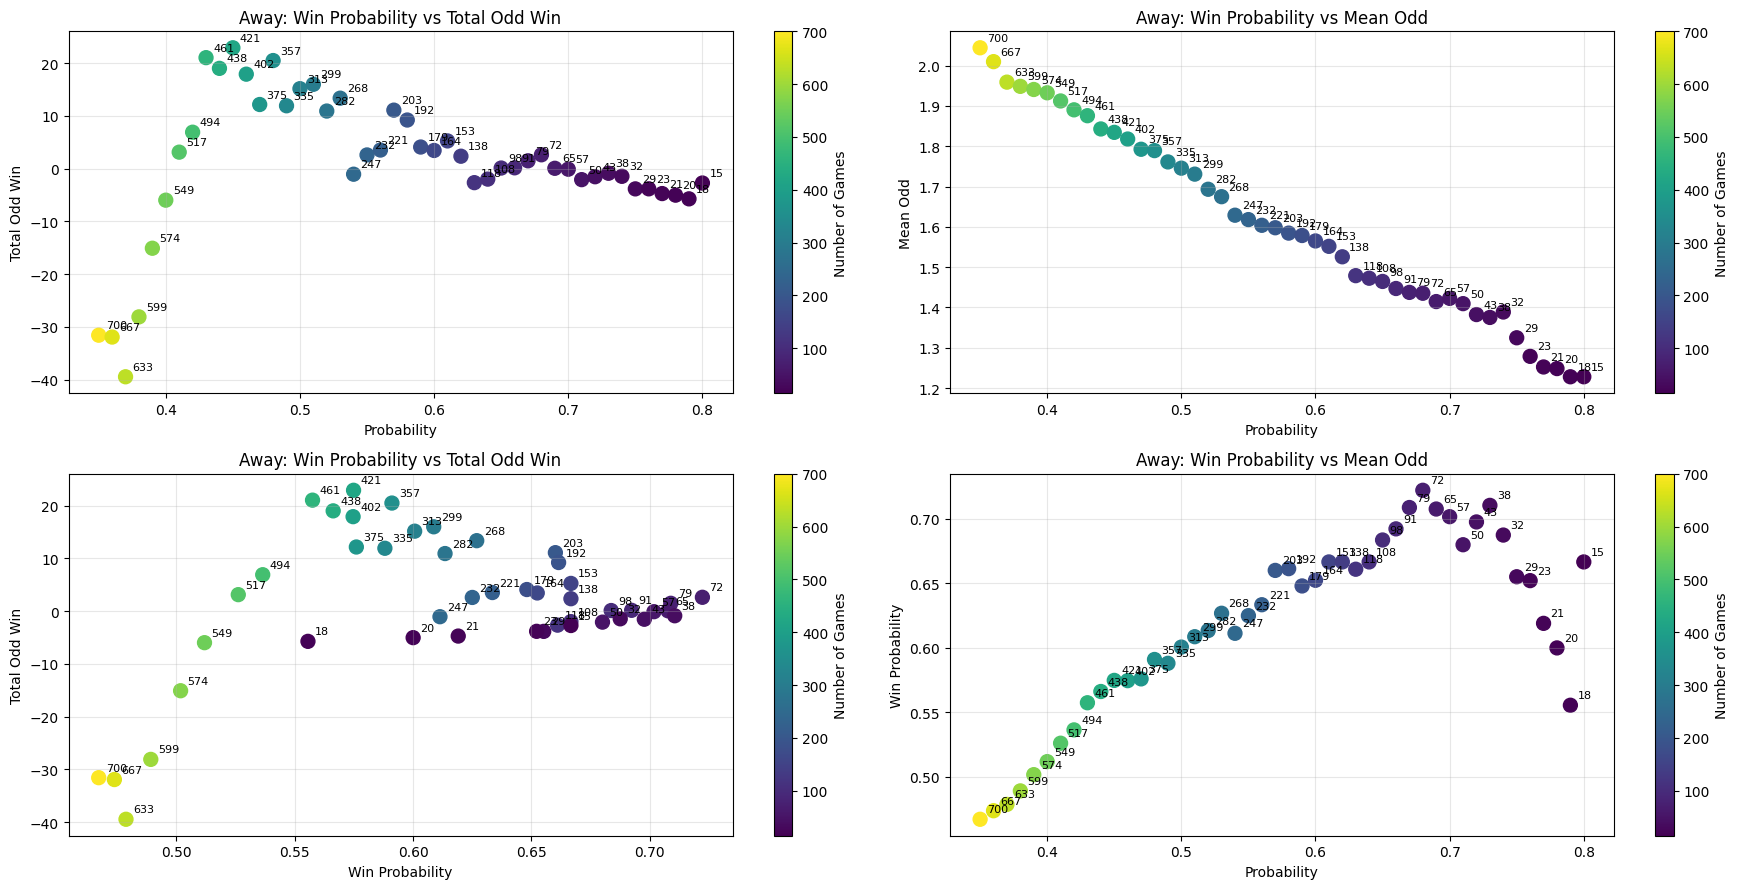

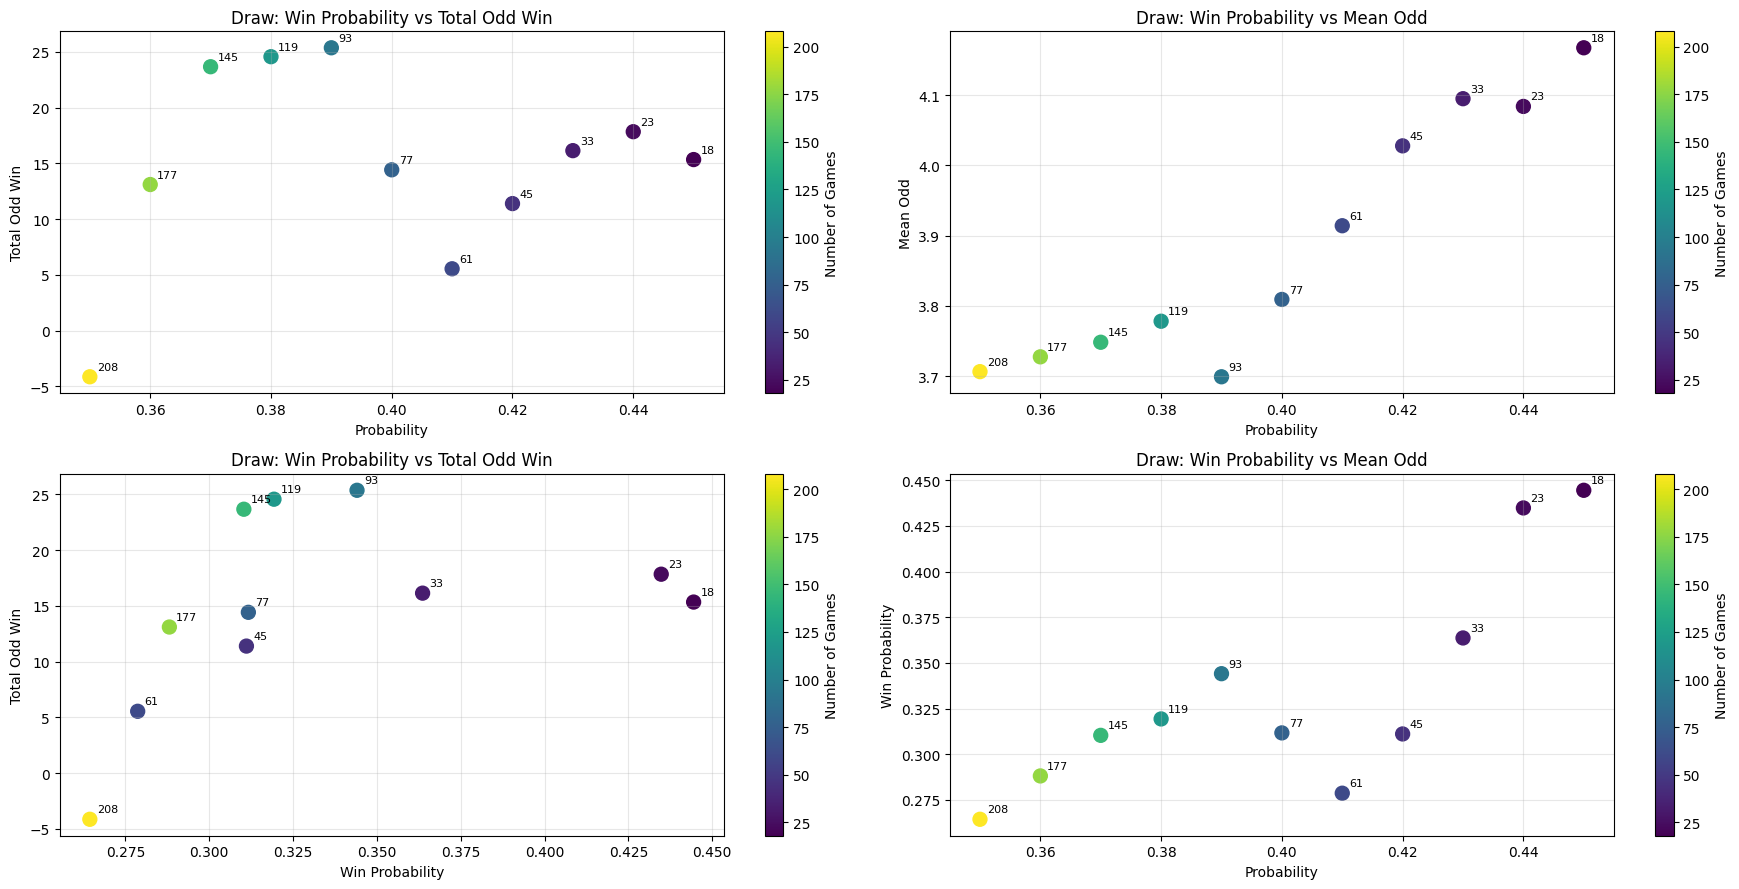

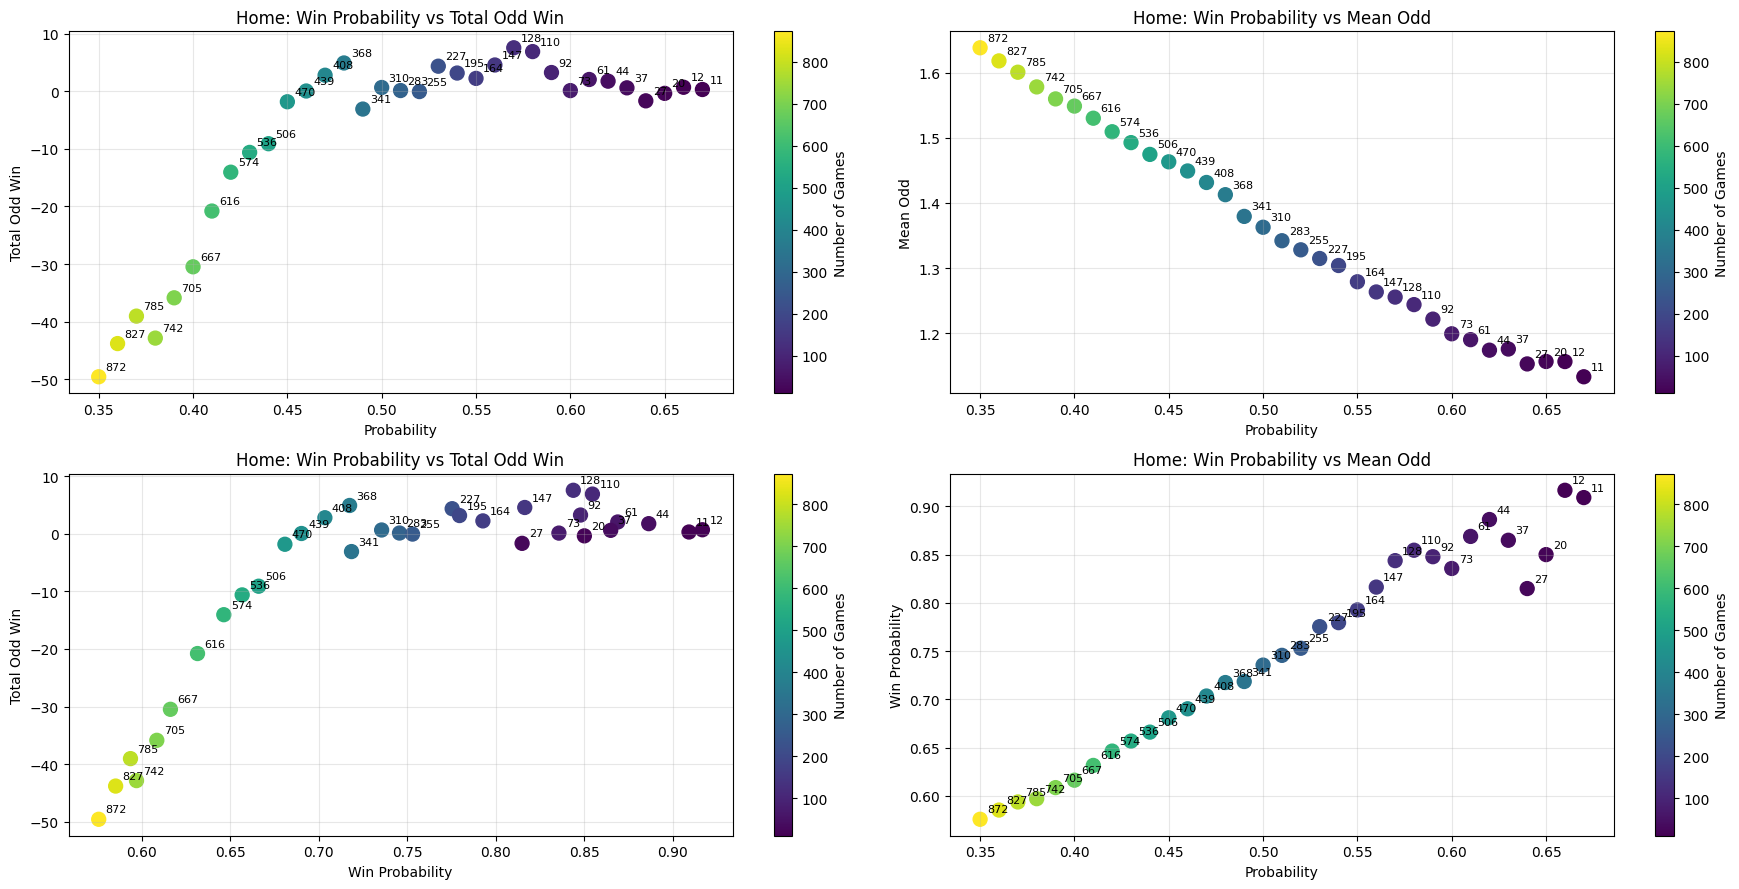

In [111]:
probabilities = tuner.get_best_models(num_models=50)[18].predict(X_test)
predictions = np.argmax(probabilities, axis=1)
create_charts_by_type(probabilities, predictions, np.array(y_test['target']), np.array(y_test['odds.B365A']), 0)
create_charts_by_type(probabilities, predictions, np.array(y_test['target']), np.array(y_test['odds.B365D']), 1)
create_charts_by_type(probabilities, predictions, np.array(y_test['target']), np.array(y_test['odds.B365H']), 2)

## Saving

In [108]:
joblib.dump(scaler, 'checkpoints/saved_scaler_model_nr_18_clasic.pkl')

['checkpoints/saved_scaler_model_nr_18_clasic.pkl']

In [ ]:
tuner.get_best_models(num_models=50)[18].save('./checkpoints/model_nr_18_clasic.keras')